## Implementation
- Signal Smoothing with Median
- Use both Median and Norm Feature
  
      * Norm: Compute Composite Feature : Euclidean Norm (x,y,z) -> 1 ; (acce x,y,x -> acce composite) ; (gry x,y,x -> gry composite)
  
- Slding Windowing : Every 100 windows  (50Hz * 2); stride of 50 => sample every 2 seconds
- Cascade Training
      - Binary Classifier : Resting vs Exercise (0 vs 1)
      - Multi Classifier  : Exercise Intensity (0 , 1, 2)
- Evaluation : Classification report

## Changes
- Implemented Subject-wise actiivty downsampling for Majority Class to be the same as minor class - preserved temporal order
- Remove Subject 9

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
import os
data_path = '/content/drive/My Drive/UofT/AppliedML/Datathon4/dataset/'
#source_df = pd.read_csv(data_path + 'Datathon #4 - mhealth Dataset - HAD7001.csv')
source_df = pd.read_csv('Datathon #4 - mhealth Dataset - HAD7001.csv')
source_df.head()


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [ ]:
activity_10_mapping = {
    0: "Resting", 1: "Standing still (1 min)", 2: "Sitting and relaxing (1 min)",
    3: "Lying down (1 min)", 4: "Walking (1 min)", 5: "Climbing stairs (1 min)",
    6: "Waist bends forward (x20)", 7: "Frontal elevation of arms (x20)",
    8: "Knees bending (crouching) (x20)", 9: "Cycling (1 min)", 10: "Jogging (1 min)",
    11: "Running (1 min)", 12: "Jump front & back (x20)" }

activity_mapping = {
    0: "Resting", 1: "Resting", 2: "Resting", 3: "Resting",
    4: "LowIntensityExercise", 5: "ModerateIntensityExercise",
    6: "ModerateIntensityExercise", 7: "ModerateIntensityExercise",
    8: "ModerateIntensityExercise", 9: "ModerateIntensityExercise",
    10: "HighIntensityExercise", 11: "HighIntensityExercise",
    12: "HighIntensityExercise" }

activity_map = {
    "Resting": 0, "LowIntensityExercise": 1, "ModerateIntensityExercise": 2, "HighIntensityExercise": 3}

source_df['activity_10_category'] = source_df['Activity'].map(activity_10_mapping)
source_df['activity_category'] = source_df['Activity'].map(activity_mapping)

activity_summary = source_df['activity_category'].value_counts()
num_subjects = source_df['subject'].nunique()

features = [
    'accel_left_x', 'accel_left_y', 'accel_left_z', 'gyro_left_x', 'gyro_left_y', 'gyro_left_z',
    'accel_right_x', 'accel_right_y', 'accel_right_z', 'gyro_right_x', 'gyro_right_y', 'gyro_right_z' ]

column_names = features +  [ "activity", "subject", "activity_10_category", "activity_category"]

source_df.columns = column_names
print("After Renaming")
print(source_df.columns)

# Drop unnecessay columns ==> just use activity as our first experiment
source_df = source_df.drop(columns = ['activity_10_category','activity'])

source_df['idx'] = source_df.index
result = source_df.groupby(["subject", "activity_category"])["idx"].agg(["min", "max"])

After Renaming
Index(['accel_left_x', 'accel_left_y', 'accel_left_z', 'gyro_left_x',
       'gyro_left_y', 'gyro_left_z', 'accel_right_x', 'accel_right_y',
       'accel_right_z', 'gyro_right_x', 'gyro_right_y', 'gyro_right_z',
       'activity', 'subject', 'activity_10_category', 'activity_category'],
      dtype='object')


In [ ]:
source_df.head(4)

,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,subject1,Resting,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,subject1,Resting,1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,subject1,Resting,2
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,subject1,Resting,3


In [ ]:
source_df.activity_category.value_counts()

activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

In [ ]:
source_df['activity'] = source_df['activity_category'].map(activity_map)
source_df.activity.value_counts()

activity
0    798576
2    119452
3     57395
1     24576
Name: count, dtype: int64

In [ ]:
#train_df = source_df[~source_df['subject'].isin(['subject5', 'subject6'])]
#test_df = source_df[source_df['subject'].isin(['subject5', 'subject6'])]

# Get the unique subjects in the dataset
unique_subjects = source_df['subject'].unique()
print(unique_subjects)

#train_ratio = 0.8
#val_ratio = 0.1
#test_ratio = 0.1

#num_train = int(len(unique_subjects) * train_ratio)
#num_test = int(len(unique_subjects) * test_ratio)
#num_val = int(len(unique_subjects) * val_ratio)
#num_train, num_test, num_val

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


['subject1' 'subject2' 'subject3' 'subject4' 'subject5' 'subject6'
 'subject7' 'subject8' 'subject9']


### We gonna build Cascade Classification

- Binaray Classification ( Resting vs Exercises)
- Exercies (Low , Moderate, High)

In [ ]:
train_subjects = ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8' ]
val_subjects = ['subject5']
test_subjects = ['subject6']

def split_bysubs(source_df, train_subjects, val_subjects, test_subjects):
    train_df = source_df[source_df['subject'].isin(train_subjects)]
    val_df = source_df[source_df['subject'].isin(val_subjects)]
    test_df = source_df[source_df['subject'].isin(test_subjects)]
    return train_df, val_df, test_df


first_step_df = source_df.copy()
second_step_df = source_df.copy()


In [ ]:
first_step_df.head(3)

,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,subject1,Resting,0,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,subject1,Resting,1,0
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,subject1,Resting,2,0


In [ ]:
first_step_df.activity_category.value_counts()

activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

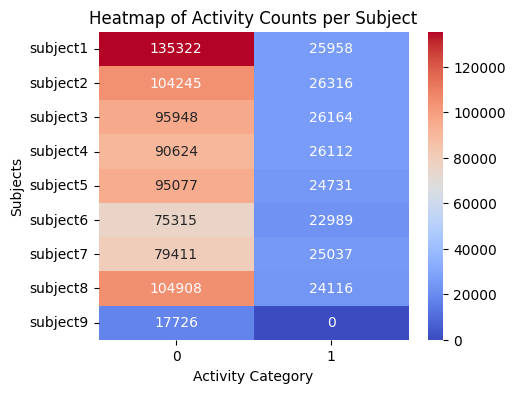

In [ ]:
first_step_df['activity'] = first_step_df['activity_category'].apply(lambda x: 0 if x == 'Resting' else 1)
count_per_subject1 = first_step_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject1, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
def stratified_downsample_ordered(df, time_column):
    downsampled_df = pd.DataFrame()

    for subject, group in df.groupby("subject"):
        activity_counts = group["activity"].value_counts()
        min_count = activity_counts.min()  # Find the minority class count

        sampled_groups = []
        for activity in activity_counts.index:
            activity_group = group[group["activity"] == activity].sort_values(time_column)  # Ensure temporal order
            if len(activity_group) > min_count:
                downsampled_group = activity_group.iloc[:min_count]  # Select first `min_count` elements
            else:
                downsampled_group = activity_group  # Keep as is if already at min count

            sampled_groups.append(downsampled_group)

        balanced_subject_df = pd.concat(sampled_groups)
        downsampled_df = pd.concat([downsampled_df, balanced_subject_df])

    return downsampled_df

### Downsample the data

In [ ]:
time_column = "idx"#assume index is the timestep
first_step_sampled_df = stratified_downsample_ordered(first_step_df, time_column="idx")

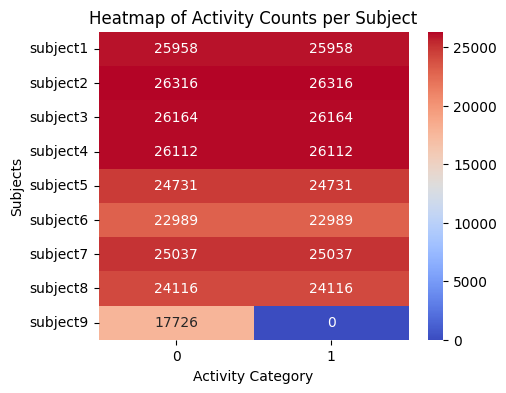

In [ ]:
count_per_subject1_ = first_step_sampled_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject1_, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
print('before', second_step_df['activity_category'].value_counts())
second_step_df = second_step_df[~(second_step_df['activity_category'] == 'Resting')]
#second_step_df = second_step_df[~(second_step_df['activity_category'].isin(['Resting', 'LowIntensityExercise']))]
print('after')
second_step_df['activity_category'].value_counts()

before activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64
after


activity_category
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

In [ ]:
activity_map

{'Resting': 0,
 'LowIntensityExercise': 1,
 'ModerateIntensityExercise': 2,
 'HighIntensityExercise': 3}

In [ ]:
second_activity_map = {
    "LowIntensityExercise": 0, "ModerateIntensityExercise": 1, "HighIntensityExercise": 2}

In [ ]:
second_step_df['activity'] = second_step_df['activity_category'].map(second_activity_map) # activity_map
second_step_df.activity.value_counts()

activity
1    119452
2     57395
0     24576
Name: count, dtype: int64

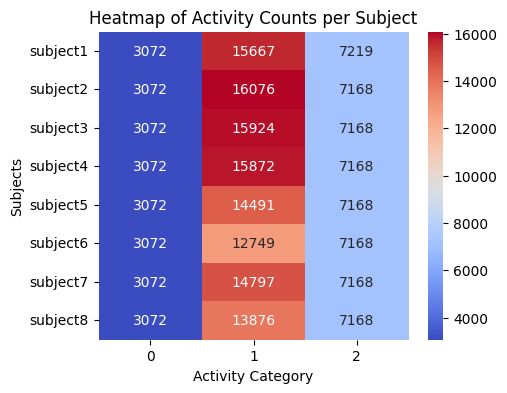

In [ ]:
count_per_subject2 = second_step_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject2, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

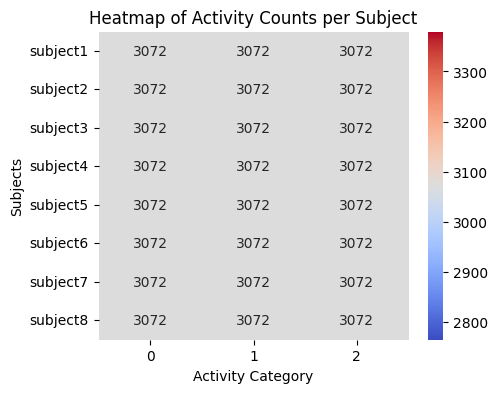

In [ ]:
time_column = "idx"#assume index is the timestep
second_step_sampled_df = stratified_downsample_ordered(second_step_df, time_column="idx")
count_per_subject2_ = second_step_sampled_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject2_, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
first_step_sampled_df.shape, second_step_sampled_df.shape

((420572, 16), (73728, 16))

In [ ]:
#first_train_df, first_val_df, first_test_df = split_bysubs(first_step_df, train_subjects, val_subjects, test_subjects)
first_train_df, first_val_df, first_test_df = split_bysubs(first_step_sampled_df, train_subjects, val_subjects, test_subjects)


second_train_df, second_val_df, second_test_df = split_bysubs(second_step_df, train_subjects, val_subjects, test_subjects)
#second_train_df, second_val_df, second_test_df = split_bysubs(second_step_sampled_df, train_subjects, val_subjects, test_subjects)

source_df['activity'] =   source_df['activity_category'].map(activity_map)
_, _, test_df = split_bysubs(source_df, train_subjects, val_subjects, test_subjects)

In [ ]:
features

['accel_left_x',
 'accel_left_y',
 'accel_left_z',
 'gyro_left_x',
 'gyro_left_y',
 'gyro_left_z',
 'accel_right_x',
 'accel_right_y',
 'accel_right_z',
 'gyro_right_x',
 'gyro_right_y',
 'gyro_right_z']

In [ ]:
features_median = [f"{feature}_median" for feature in features]
features_median

['accel_left_x_median',
 'accel_left_y_median',
 'accel_left_z_median',
 'gyro_left_x_median',
 'gyro_left_y_median',
 'gyro_left_z_median',
 'accel_right_x_median',
 'accel_right_y_median',
 'accel_right_z_median',
 'gyro_right_x_median',
 'gyro_right_y_median',
 'gyro_right_z_median']

In [ ]:
features = [
    'accel_left_x', 'accel_left_y', 'accel_left_z', 'gyro_left_x', 'gyro_left_y', 'gyro_left_z',
    'accel_right_x', 'accel_right_y', 'accel_right_z', 'gyro_right_x', 'gyro_right_y', 'gyro_right_z' ]
features_median = [f"{feature}_median" for feature in features]
norm_features = ['accel_left_norm', 'accel_right_norm', 'gyro_left_norm', 'gyro_right_norm']
# X = features , y = activity

def create_windows(df, window_size=100, step_size=50):
    sequences, labels = [], []

    for subj in df['subject'].unique():
        print(f'Processing subject {subj}')
        subj_df = df[df['subject'] == subj]

        for act in subj_df['activity'].unique():
            print(f'  Activity: {act}')
            act_df = subj_df[subj_df['activity'] == act].copy()
            for feature in features:
                act_df[f'{feature}_median'] = act_df[feature].rolling(window=3, min_periods=1).median()

            act_df = act_df.dropna()

            act_df['accel_left_norm'] = np.sqrt(
                act_df['accel_left_x_median']**2 + act_df['accel_left_y_median']**2 + act_df['accel_left_z_median']**2 )

            act_df['accel_right_norm'] = np.sqrt(
                act_df['accel_right_x_median']**2 + act_df['accel_right_y_median']**2 + act_df['accel_right_z_median']**2 )

            act_df['gyro_left_norm'] = np.sqrt(
                act_df['gyro_left_x_median']**2 + act_df['gyro_left_y_median']**2 + act_df['gyro_left_z_median']**2)

            act_df['gyro_right_norm'] = np.sqrt(
                act_df['gyro_right_x_median']**2 + act_df['gyro_right_y_median']**2 + act_df['gyro_right_z_median']**2)

            for i in range(0, len(act_df) - window_size + 1, step_size):
                window = act_df.iloc[i:i+window_size]
                sequences.append(window[features_median + norm_features].values)  # use both norm and median
                # sequences.append(window[norm_features].values)  # Dimension reduciton only use Norm

                labels.append(act), window
    return np.array(sequences), np.array(labels)

In [ ]:
#X_train1, y_train1 = create_windows(first_train_df.copy())

In [ ]:
# Create time windows
X_train1, y_train1 = create_windows(first_train_df)
X_val1, y_val1 = create_windows(first_val_df)
X_test1, y_test1 = create_windows(first_test_df)
first_train_df.head(1)

Processing subject subject1
  Activity: 0
  Activity: 1
Processing subject subject2
  Activity: 0
  Activity: 1
Processing subject subject3
  Activity: 0
  Activity: 1
Processing subject subject4
  Activity: 0
  Activity: 1
Processing subject subject7
  Activity: 0
  Activity: 1
Processing subject subject8
  Activity: 0
  Activity: 1
Processing subject subject5
  Activity: 0
  Activity: 1
Processing subject subject6
  Activity: 0
  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
0,2.1849,-9.6967,0.63077,0.1039,-0.84053,-0.68762,-8.6499,-4.5781,0.18776,-0.44902,-1.0103,0.034483,subject1,Resting,0,0


In [ ]:
X_train1[0, 0, :]

array([ 2.1849    , -9.6967    ,  0.63077   ,  0.1039    , -0.84053   ,
       -0.68762   , -8.6499    , -4.5781    ,  0.18776   , -0.44902   ,
       -1.0103    ,  0.034483  ,  9.95980169,  9.78851487,  1.09092032,
        1.10612573])

In [ ]:
print("Shapes:", X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

Shapes: (6132, 100, 16) (6132,) (986, 100, 16) (986,) (916, 100, 16) (916,)


In [ ]:
# Create time windows
X_train2, y_train2 = create_windows(second_train_df)
X_val2, y_val2 = create_windows(second_val_df)
X_test2, y_test2 = create_windows(second_test_df)
second_train_df.head(1)

Processing subject subject1
  Activity: 0
  Activity: 1
  Activity: 2
Processing subject subject2
  Activity: 1
  Activity: 0
  Activity: 2
Processing subject subject3
  Activity: 0
  Activity: 1
  Activity: 2
Processing subject subject4
  Activity: 1
  Activity: 0
  Activity: 2
Processing subject subject7
  Activity: 1
  Activity: 0
  Activity: 2
Processing subject subject8
  Activity: 0
  Activity: 1
  Activity: 2
Processing subject subject5
  Activity: 0
  Activity: 1
  Activity: 2
Processing subject subject6
  Activity: 0
  Activity: 1
  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
28160,4.3791,-10.206,0.14805,0.59184,-0.52345,0.48919,-7.0015,-10.089,3.0789,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28160,0


In [ ]:
# Create time windows
X_train2[0, 0, :]

array([  4.3791    , -10.206     ,   0.14805   ,   0.59184   ,
        -0.52345   ,   0.48919   ,  -7.0015    , -10.089     ,
         3.0789    ,  -0.57647   ,  -0.59959   ,   0.75431   ,
        11.10679394,  12.66051138,   0.92929077,   1.1228577 ])

In [ ]:
print("Shapes:", X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape)

Shapes: (3048, 100, 16) (3048,) (490, 100, 16) (490,) (455, 100, 16) (455,)


In [ ]:
parcel1 = (X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
parcel2 = (X_train2, y_train2, X_val2, y_val2, X_test2, y_test2)

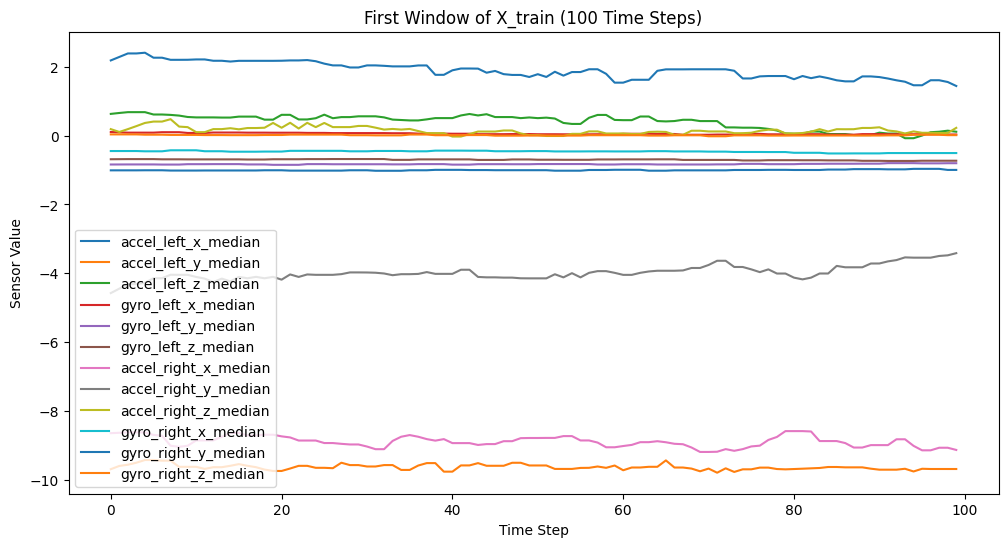

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_median):
    plt.plot(X_train1[0, :, i], label=feature)  # First sequence, all time steps
plt.title("First Window of X_train (100 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from model import *

def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


def train_model(parcel , model_type='EnhancedLSTM',
                 hidden_size=64, learning_rate=0.001, weight_decay=1e-4, num_epochs=30, patience=7, batch_size=8):
    device = get_best_device()
    print(f"Using device: {device}")
    X_train, y_train, X_val, y_val, X_test, y_test = parcel
    encoder = LabelEncoder()
    y_train_enc = encoder.fit_transform(y_train)
    y_val_enc = encoder.transform(y_val)
    y_test_enc = encoder.transform(y_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    X_train_t, y_train_t = to_tensor(X_train, y_train_enc)
    X_val_t, y_val_t = to_tensor(X_val, y_val_enc)
    X_test_t, y_test_t = to_tensor(X_test, y_test_enc)

    # Verify the split
    print(f"Train Subjects: {train_subjects}")
    print(f"Validation Subjects: {val_subjects}")
    print(f"Test Subjects: {test_subjects}")
    # (num_samples, window_size, num_features)
    print(f"Train shape: {X_train_t.shape}, Validation shape: {X_val_t.shape}, Test shape: {X_test_t.shape}")

    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#don't suffle timeseries data
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = X_train_t.shape[-1]
    num_classes = len(encoder.classes_)

    weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
    weights = torch.tensor(weights, dtype=torch.float32)

    if model_type == 'EnhancedLSTM':
        model = EnhancedLSTMNet(input_size, hidden_size, num_classes)
    elif model_type == 'LSTM':
        model = LSTMNet(input_size, hidden_size, num_classes)
    else:
        model = RNNNet(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)


    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_loss = float("inf")
    trigger = 0

    for epoch in range(num_epochs):
      model.train() # trainign
      epoch_train_loss , correct_train , total_train = 0, 0, 0


      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()

          epoch_train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += y_batch.size(0)
          correct_train += (predicted == y_batch).sum().item()

      epoch_train_loss /= len(train_loader)
      epoch_train_acc = 100 * correct_train / total_train

      model.eval() # validation
      epoch_val_loss, correct_val, total_val = 0, 0, 0

      with torch.no_grad():
          for X_batch, y_batch in val_loader:
              val_out = model(X_batch)
              val_loss = criterion(val_out, y_batch)
              epoch_val_loss += val_loss.item()
              _, predicted = torch.max(val_out.data, 1)
              total_val += y_batch.size(0)
              correct_val += (predicted == y_batch).sum().item()

      epoch_val_loss /= len(val_loader)
      epoch_val_acc = 100 * correct_val / total_val

      train_losses.append(epoch_train_loss)
      val_losses.append(epoch_val_loss)
      train_accuracies.append(epoch_train_acc)
      val_accuracies.append(epoch_val_acc)

      print(f"Epoch {epoch+1}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.2f}%, "
          f"val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.2f}%, "
          f"lr={optimizer.param_groups[0]['lr']:.6f}")

      scheduler.step(epoch_val_loss)#scheduler with validation loss

      if epoch_val_loss < best_loss: # early stop
          best_loss = epoch_val_loss
          trigger = 0
          torch.save(model.state_dict(), "best_model.pth")  # Save best model

      else:
          trigger += 1
          if trigger > patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

    model.load_state_dict(torch.load("best_model.pth")) # load the bes t model
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch).argmax(dim=1).cpu().numpy()
            labels = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
        print(len(all_preds), len(all_preds))


    rresult = (test_loader, all_preds, all_labels)

    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    pred_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 8))
    sns.heatmap(pred_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1)
    plt.title("Classification Report Heatmap")
    plt.show()

    results_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
    }
    return model, rresult , results_dict, report

Using device: mps
Train Subjects: ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8']
Validation Subjects: ['subject5']
Test Subjects: ['subject6']
Train shape: torch.Size([6132, 100, 16]), Validation shape: torch.Size([986, 100, 16]), Test shape: torch.Size([916, 100, 16])
Epoch 1: train_loss=0.9288, train_acc=60.08%, val_loss=0.7223, val_acc=50.00%, lr=0.010000
Epoch 2: train_loss=0.7475, train_acc=41.83%, val_loss=2.0077, val_acc=50.00%, lr=0.010000
Epoch 3: train_loss=0.7831, train_acc=54.24%, val_loss=0.7212, val_acc=50.00%, lr=0.010000
Epoch 4: train_loss=1.0182, train_acc=57.44%, val_loss=0.9380, val_acc=59.13%, lr=0.010000
Epoch 5: train_loss=0.7975, train_acc=47.93%, val_loss=0.8781, val_acc=50.00%, lr=0.010000
Epoch 6: train_loss=0.7857, train_acc=44.77%, val_loss=0.7715, val_acc=50.00%, lr=0.010000
Epoch 7: train_loss=0.7237, train_acc=39.50%, val_loss=0.6198, val_acc=50.00%, lr=0.005000
Epoch 8: train_loss=0.6413, train_acc=51.78%, val_loss=0.5991, val_

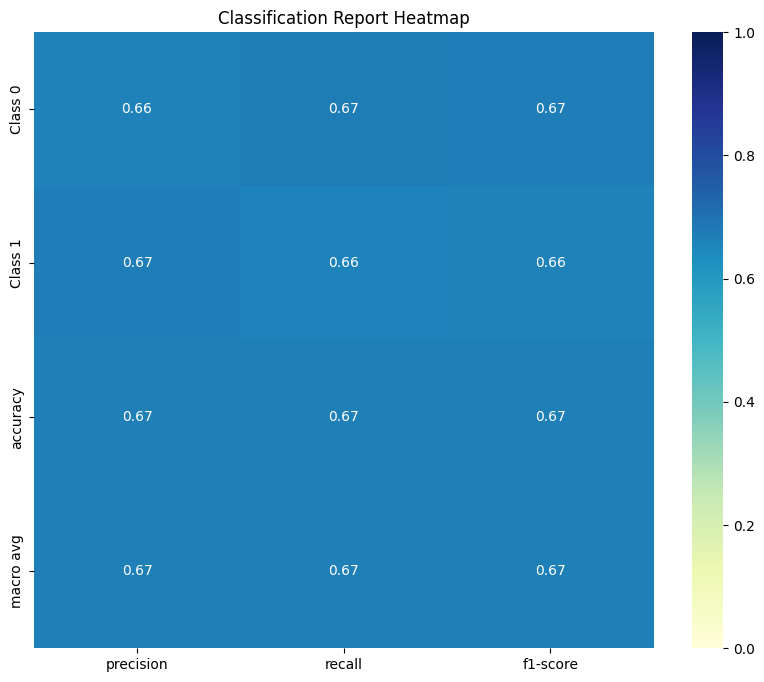

In [ ]:
binary_model, result1, results_dict1, report1   = train_model(parcel1, hidden_size=32, learning_rate=0.01, weight_decay=1e-4, num_epochs=300, patience=10, batch_size=8)

Using device: mps
Train Subjects: ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8']
Validation Subjects: ['subject5']
Test Subjects: ['subject6']
Train shape: torch.Size([3048, 100, 16]), Validation shape: torch.Size([490, 100, 16]), Test shape: torch.Size([455, 100, 16])
Epoch 1: train_loss=0.7450, train_acc=78.38%, val_loss=0.5344, val_acc=83.47%, lr=0.001000
Epoch 2: train_loss=0.3392, train_acc=85.47%, val_loss=0.1952, val_acc=87.76%, lr=0.001000
Epoch 3: train_loss=0.2246, train_acc=90.12%, val_loss=0.1942, val_acc=88.57%, lr=0.001000
Epoch 4: train_loss=0.2002, train_acc=95.41%, val_loss=0.1500, val_acc=95.31%, lr=0.001000
Epoch 5: train_loss=0.1624, train_acc=96.26%, val_loss=0.0811, val_acc=98.16%, lr=0.001000
Epoch 6: train_loss=0.0543, train_acc=99.11%, val_loss=0.0286, val_acc=99.80%, lr=0.001000
Epoch 7: train_loss=0.0722, train_acc=98.65%, val_loss=0.2405, val_acc=96.12%, lr=0.001000
Epoch 8: train_loss=0.1389, train_acc=97.54%, val_loss=0.0511, val_

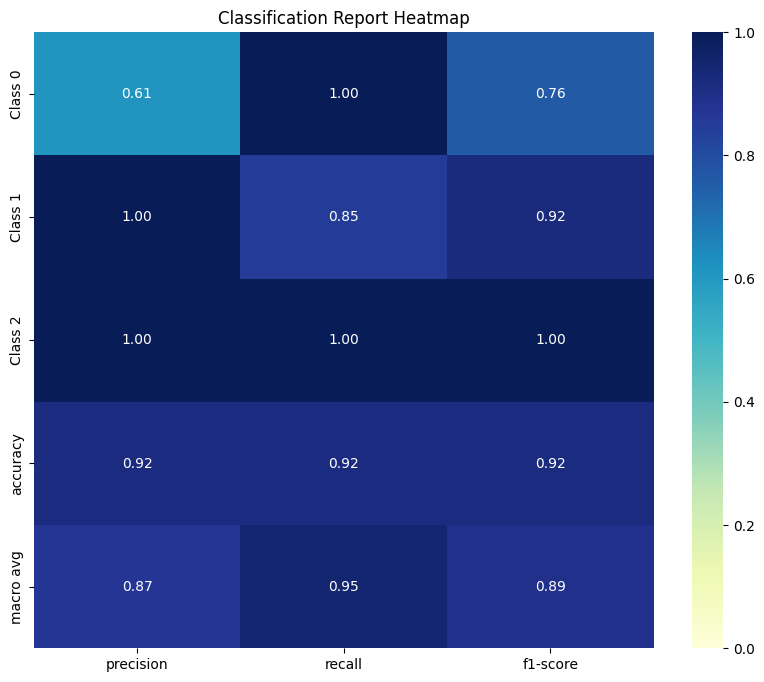

In [ ]:
multiclass_model,result2,  results_dict2, report2 = train_model(parcel2, hidden_size=64, learning_rate=0.001, weight_decay=1e-4, num_epochs=300, patience=10, batch_size=8)

In [ ]:
test_loader1, pred1, label1 = result1
test_loader2, pred2, label2 = result2

In [ ]:
pred1, label1 = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader1:
        preds = binary_model(X_batch).argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()
        pred1.extend(preds)
        label1.extend(labels)
    print(len(pred1), len(label1))


916 916


In [ ]:
pred2, label2 = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader2:
        preds = multiclass_model(X_batch).argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()
        pred2.extend(preds)
        label2.extend(labels)
    print(len(pred2), len(label2))

455 455


In [ ]:
r1 = pd.DataFrame([label1, pred1]).T

r1.columns = ['y_true', 'y_pred']
r2 = pd.DataFrame([label2, pred2]).T
r2.columns = ['y_true', 'y_pred']
r2 = r2+1 # Add 1 to make label consistant ### 2nd multiclass model label should start with 1 instead of 0

r1_0 = r1[r1['y_true']==0]
r1_1 = r1[r1['y_true']==1]
cascade_diff = r1_1.shape[0] - r2.shape[0] ##offset due to timeseries processing
r1_1 = r1_1[:-cascade_diff]
r1 = pd.concat([r1_0, r1_1])
r1 = r1.reset_index(drop=True)
offset = r1[r1.y_true==0].shape[0]+1
offset

459

In [ ]:
r1.value_counts()

y_true  y_pred
0       0         308
1       1         299
        0         156
0       1         150
Name: count, dtype: int64

In [ ]:
r2.value_counts()

y_true  y_pred
2       2         215
3       3         142
1       1          60
2       1          38
Name: count, dtype: int64

In [ ]:
r1.y_pred.value_counts()

y_pred
0    464
1    449
Name: count, dtype: int64

In [ ]:
#create placeholder for multiclass prediction
ddd = pd.DataFrame({ 'y_true': np.nan,   'y_pred': np.nan   }, index=np.arange(1,offset ))

print(ddd.head())
dr2 = pd.concat([ddd,r2])
dr2 = dr2.reset_index(drop=True)

   y_true  y_pred
1     NaN     NaN
2     NaN     NaN
3     NaN     NaN
4     NaN     NaN
5     NaN     NaN


In [ ]:
r1.shape, dr2.shape

((913, 2), (913, 2))

In [ ]:
r1.to_csv('r1.csv', index=False)
dr2.to_csv('dr2.csv', index=False)

In [ ]:
indices_pred_1 = r1[(r1['y_pred'] == 1) & (r1.index >= offset)].index
indices_pred_2 = r1[(r1['y_pred'] == 1) & (r1.index < offset)].index
indices_pred_1

Index([459, 465, 466, 467, 473, 480, 486, 487, 489, 490,
       ...
       903, 904, 905, 906, 907, 908, 909, 910, 911, 912],
      dtype='int64', length=299)

In [ ]:
print(r1.loc[indices_pred_2, 'y_pred'].shape)
num_classes = 3
num_indices = len(indices_pred_2)
assignments = np.tile([1, 2, 3], num_indices // num_classes + 1)[:num_indices]
np.random.shuffle(assignments)
print(assignments.shape)
r1.loc[indices_pred_2, 'y_pred'] = assignments

(150,)
(150,)


In [ ]:
r1.loc[indices_pred_1, 'y_pred'] = dr2.loc[indices_pred_1, 'y_pred']
r1.loc[indices_pred_1, 'y_true'] = dr2.loc[indices_pred_1, 'y_true']

In [ ]:
r1.to_csv('Cascade_Training_v3_resut.csv',index=False)

In [ ]:
result_report = classification_report(r1.y_true,r1.y_pred, output_dict=True , digits = 2)
report_df = pd.DataFrame(result_report).transpose()
report_df

,precision,recall,f1-score,support
0,0.663793,0.672489,0.668113,458.000000
1,0.174757,0.103448,0.129964,174.000000
2,0.696970,0.766667,0.730159,150.000000
3,0.723757,1.000000,0.839744,131.000000
accuracy,0.626506,0.626506,0.626506,0.626506
macro avg,0.564819,0.635651,0.591995,913.000000
weighted avg,0.584647,0.626506,0.600372,913.000000


In [ ]:
a = classification_report(r2.y_true,r2.y_pred, output_dict=True , digits = 2)
d = pd.DataFrame(a).transpose()
d

,precision,recall,f1-score,support
1,0.612245,1.000000,0.759494,60.000000
2,1.000000,0.849802,0.918803,253.000000
3,1.000000,1.000000,1.000000,142.000000
accuracy,0.916484,0.916484,0.916484,0.916484
macro avg,0.870748,0.949934,0.892766,455.000000
weighted avg,0.948867,0.916484,0.923136,455.000000
